In [52]:
import pandas as pd
import numpy as np

In [53]:
stas = pd.read_csv('../DeconstructingGastrulation-Data/tracked_data.csv')

stas.head()

,Unnamed: 0.1,Unnamed: 0,x,y,z,frame,particle,dx,dy,dz
0,0,0,252.766403,24.680962,103.450500,1,0,NaN,NaN,NaN
1,1,1,252.504501,24.682747,103.450500,1,1,NaN,NaN,NaN
2,2,2,248.314102,24.750181,103.450500,1,2,NaN,NaN,NaN
3,3,3,247.528397,24.807440,109.474197,1,3,NaN,NaN,NaN
4,4,4,246.218903,24.629951,106.069504,1,4,NaN,NaN,NaN


In [54]:
tracked_and_rescaled = stas.copy()


tracked_and_rescaled['x'] = tracked_and_rescaled['x'] - tracked_and_rescaled['x'].mean()-25
tracked_and_rescaled['y'] = (tracked_and_rescaled['y'] - tracked_and_rescaled['y'].mean())*1.08
tracked_and_rescaled['z'] = tracked_and_rescaled['z'] - tracked_and_rescaled['z'].mean()+10

angle = -np.pi/180*8
tracked_and_rescaled['x'], tracked_and_rescaled['z'] = tracked_and_rescaled['x']*np.cos(angle) - tracked_and_rescaled['z']*np.sin(angle), tracked_and_rescaled['x']*np.sin(angle) + tracked_and_rescaled['z']*np.cos(angle)

s = 3.6
tracked_and_rescaled['x'] = tracked_and_rescaled['x']/s
tracked_and_rescaled['y'] = tracked_and_rescaled['y']/s
tracked_and_rescaled['z'] = tracked_and_rescaled['z']/s

# redefine dx, dy, dz
tracked_and_rescaled['dx'] = tracked_and_rescaled['x'].groupby(tracked_and_rescaled['particle']).diff()
tracked_and_rescaled['dy'] = tracked_and_rescaled['y'].groupby(tracked_and_rescaled['particle']).diff()
tracked_and_rescaled['dz'] = tracked_and_rescaled['z'].groupby(tracked_and_rescaled['particle']).diff()

tracked_and_rescaled.to_csv('../DeconstructingGastrulation-Data/tracked_data_rescaled.csv', index=False)

KeyboardInterrupt: 

In [ ]:
# count nans in dx
print('percefntage of NaNs in dx:', tracked_and_rescaled['dx'].isna().sum()/len(tracked_and_rescaled['dx'])*100)

percefntage of NaNs in dx: 18.563208084147494


In [78]:
import h5py
import numpy as np

with h5py.File('../CodePass2/runs/no_close_even_long_term_3.hdf5', 'r') as f:
    sim = np.array(f['x'])

    

In [ ]:
# interactive plotting
import matplotlib.pyplot as plt
from IPython.display import HTML




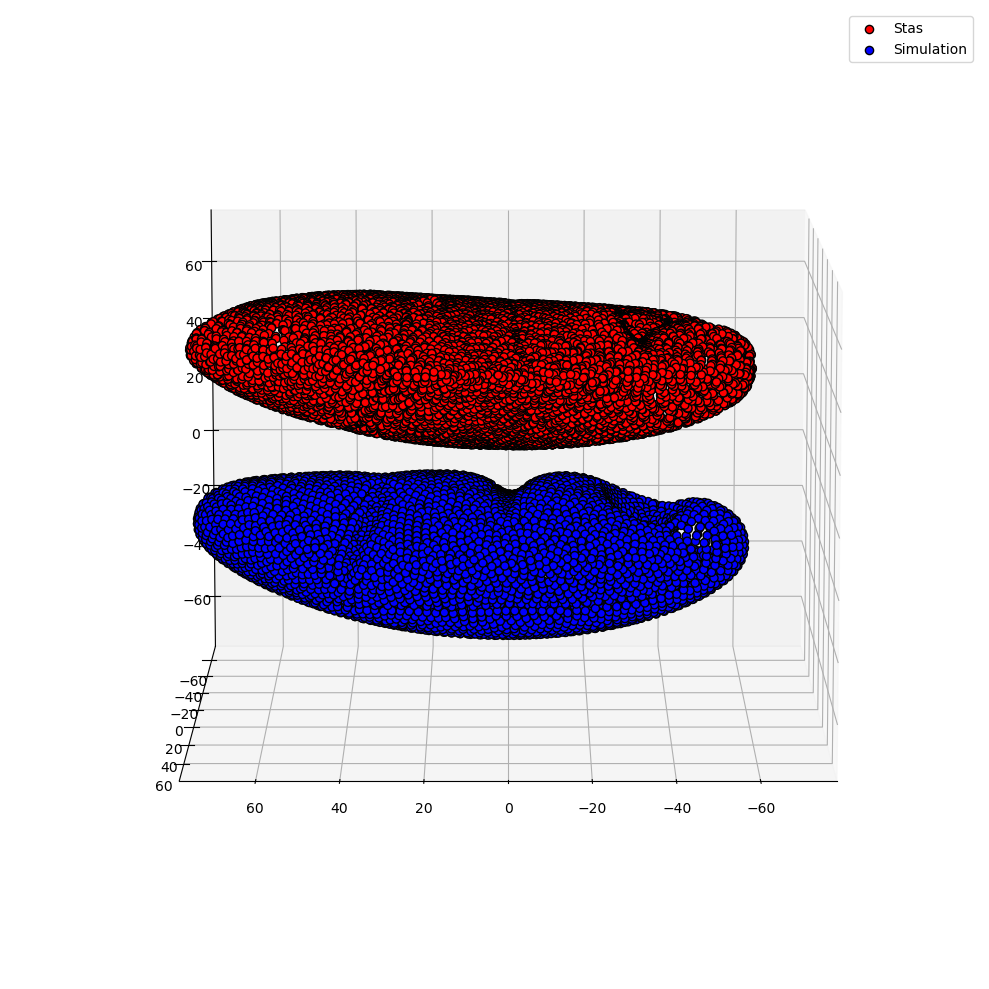

In [81]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# make animation
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize = (10,10), tight_layout = True)
ax = fig.add_subplot(111, projection='3d',)



def func(i):
    ax.clear()
    
    frame1 = tracked_and_rescaled[tracked_and_rescaled['frame'] == i+1]



    ax.scatter(-frame1['x'], frame1['y'], frame1['z']+35, c='r', marker='.', alpha = 1, label = 'Stas', s = 140, edgecolors='k', zorder = 10)

    x,y,z = sim[i*100+1].T


    ax.scatter(-x, y, z-25, c='b', marker='.', alpha = 1, label = 'Simulation', s = 140, edgecolors='k')

    plt.xlim(-75,75)
    plt.ylim(-75,75)
    ax.set_zlim(-75,75)

    # set the camera angle
    ax.view_init(elev=10, azim=90)

    plt.legend()
    return ax

ani = FuncAnimation(fig, func, frames=np.arange(0, 20), interval=100)

ani.save('comparison_1_0.mp4', writer='ffmpeg', fps=2)

plt.show()

In [ ]:
tracked_and_rescaled[tracked_and_rescaled.frame == 5]

,Unnamed: 0.1,Unnamed: 0,x,y,z,frame,particle,dx,dy,dz
42668,42668,42668,-4.811905,-26.555293,0.320071,5,1,0.072043,-0.000707,-0.010125
42669,42669,42669,-4.904197,-26.540613,0.186111,5,0,0.061918,0.006179,-0.082167
42670,42670,42670,-5.964577,-26.535062,0.482068,5,2,-0.061918,-0.007067,0.082167
42671,42671,42671,-6.265205,-26.572717,1.479363,5,4,0.154210,0.000620,0.051793
42672,42672,42672,-7.294041,-26.555366,1.477026,5,5,0.061918,0.002222,-0.082167
...,...,...,...,...,...,...,...,...,...,...
53295,53295,53295,-27.640261,23.710265,4.116107,5,10652,-0.206003,0.000000,0.102417
53296,53296,53296,-28.711934,23.710265,4.854440,5,10653,-0.185753,0.000156,0.246500
53297,53297,53297,-20.425936,23.860622,3.175665,5,10657,-0.113710,0.006606,0.236377
53298,53298,53298,-20.879609,23.817651,3.606750,5,10658,-0.051793,-0.027191,0.154210


In [84]:
from scipy.spatial.distance import cdist


def get_scores(time_index, N_closest = 5, timescale = 50):
    sim_d = (sim[timescale*(time_index+1)] - sim[timescale*time_index])
    sim_poss = sim[timescale*time_index+1]

    scores = np.empty(sim_poss.shape[0])
    for i in range(sim_poss.shape[0]):
        print(f"{int(i/sim_poss.shape[0]*100)}%", end = '\r')

        data = tracked_and_rescaled[tracked_and_rescaled.frame == time_index]

        # calculate the distance between sp and all points in tracked_and_rescaled
        d = cdist([sim_poss[i]], data[['x', 'y', 'z']].values, 'euclidean')
        # find the closest points
        closest = np.argsort(d)[0][:N_closest]

        # get average dx, dy, dz in data
        dxs = data['dx'].iloc[closest].dropna()
        dys = data['dy'].iloc[closest].dropna()
        dzs = data['dz'].iloc[closest].dropna()

        if all(np.isnan(dxs)) or all(np.isnan(dys)) or all(np.isnan(dzs)):
            continue

        dx = dxs.mean()
        dy = dys.mean()
        dz = dzs.mean()
        
        # print("Here")
        # # compute the score
        # print(sim_d[i])
        # print(dx, dy, dz,)
        # print(dxs.std(), dys.std(), dzs.std())

        if np.isnan(dx) or np.isnan(dy) or np.isnan(dz):
            continue

        data_d_vector = np.array([dx, dy, dz])
        sim_d_vector = sim_d[i]

        # normalize
        data_d_vector = data_d_vector / np.linalg.norm(data_d_vector)
        sim_d_vector = sim_d_vector / np.linalg.norm(sim_d_vector)

        # compute the score
        score = np.dot(data_d_vector, sim_d_vector)

        score = np.arccos(score)

        # score = np.mean([np.abs(dx), np.abs(dy), np.abs(dz)])
        # score = np.mean([np.abs(sim_d[i][0] - dx), np.abs(sim_d[i][1] - dy), np.abs(sim_d[i][2] - dz)])
        scores[i] = score

    return scores

# time_indices = [1,2,3,4,5,6]
# N_closest = [3,5,10,15]
# timescales = [10, 20, 50, 70]
# overview = np.empty((len(time_indices), len(N_closest), len(timescales)))

# for i, time_index in enumerate(time_indices):
#     for j, N in enumerate(N_closest):
#         for k, timescale in enumerate(timescales):
#             print(f"time_index: {time_index}, N: {N}, timescale: {timescale}")
#             scores = get_scores(time_index, N, timescale)
#             overview[i,j,k] = np.mean(scores)

20.0

In [85]:
color_scores = []
timescale = 100
for time_index in range(20):
    print(f"{int(time_index)} out of {20}", end = '\n')
    scores = get_scores(time_index+2, 15, timescale)
    color_scores.append(scores)



0 out of 40
1 out of 40
2 out of 40
3 out of 40
4 out of 40
5 out of 40
6 out of 40
7 out of 40
8 out of 40
9 out of 40
10 out of 40
11 out of 40
12 out of 40
13 out of 40
14 out of 40
15 out of 40
16 out of 40
17 out of 40
18 out of 40
19 out of 40


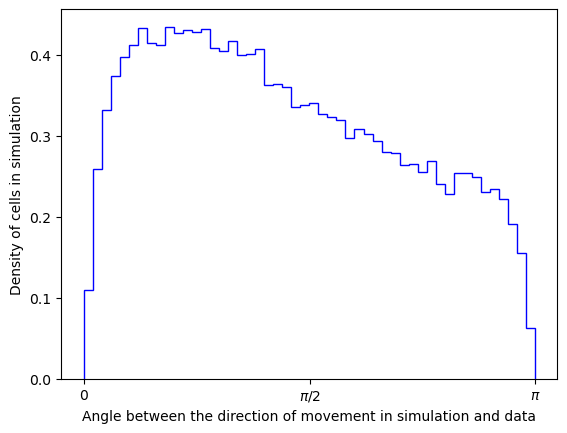

In [112]:

flat_scores = np.array(color_scores[5:15]).flatten()
plt.hist(flat_scores[flat_scores < 4], bins = 50, histtype='step', color='b', label = '15th frame', density = True)
plt.xlabel('Angle between the direction of movement in simulation and data')
plt.ylabel('Density of cells in simulation')
plt.xticks([0, np.pi/2,  np.pi], ['0', r'$\pi/2$', r'$\pi$'])
plt.show()

C:\Users\jakob\AppData\Local\Temp\ipykernel_22344\1904045325.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ani.save('comparison_1_2.mp4', writer='ffmpeg', fps=2)
c:\Users\jakob\miniconda3\envs\reworked\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


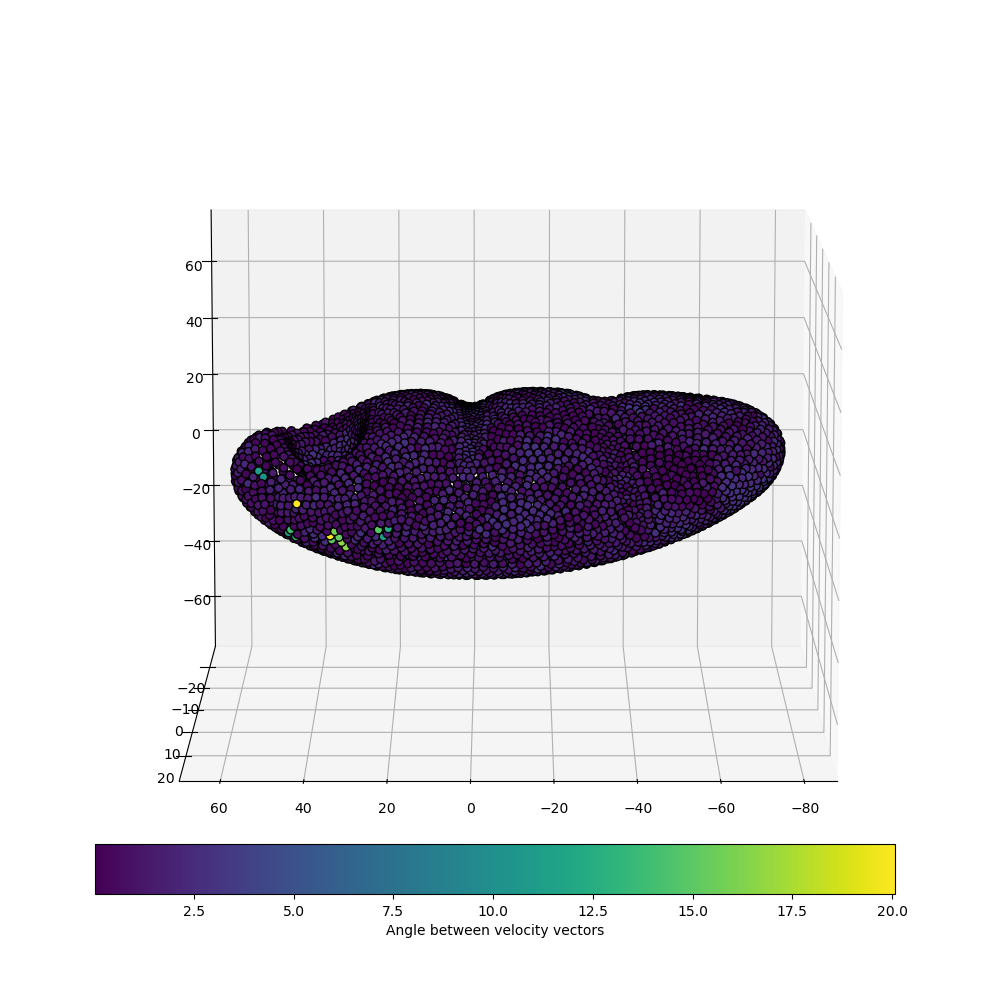

In [87]:
fig = plt.figure(figsize = (10,10), tight_layout = True)
ax = fig.add_subplot(111, projection='3d',)

colorbarax = fig.add_axes([0.1, 0.1, 0.8, 0.05])

def func(i):

    ax.clear()
    frame1 = tracked_and_rescaled[tracked_and_rescaled['frame'] == i+1]



    # ax.scatter(frame1['x'], frame1['y'], frame1['z']+35, c='r', marker='.', alpha = 1, label = 'Stas', s = 140, edgecolors='k', zorder = 10)

    x,y,z = sim[i*int(timescale/4)+1].T

    # nextc = np.clip(color_scores[int((i)/4+1)], -1, 1)

    # c = np.clip(color_scores[int(i/4)], -1, 1)
    
    nextc = color_scores[int((i)/4+1)]
    c = color_scores[int(i/4)]

    # lerp 
    act_c = (1-i%4/4)*c + (i%4/4)*nextc


    p = ax.scatter(x, y, z, c=act_c, marker='.', alpha = 1, label = 'Simulation', s = 140, edgecolors='k')

    plt.xlim(-75,75)
    plt.ylim(-75,75)
    ax.set_zlim(-75,75)

    # make colorbar
    cbar = plt.colorbar(p, cax=colorbarax, orientation='horizontal')
    cbar.set_label('Angle between velocity vectors')

    


    # set the camera angle
    ax.view_init(elev=10, azim=90)

    return ax

ani = FuncAnimation(fig, func, frames=np.arange(0, 60), interval=100)

ani.save('comparison_1_2.mp4', writer='ffmpeg', fps=2)

plt.show()

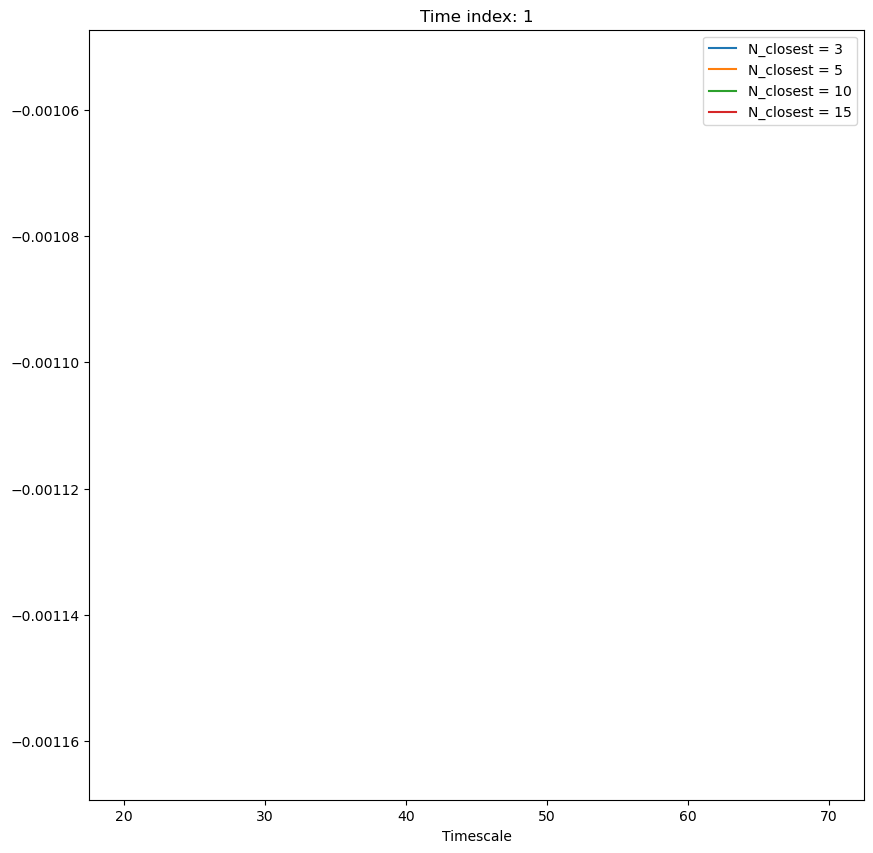

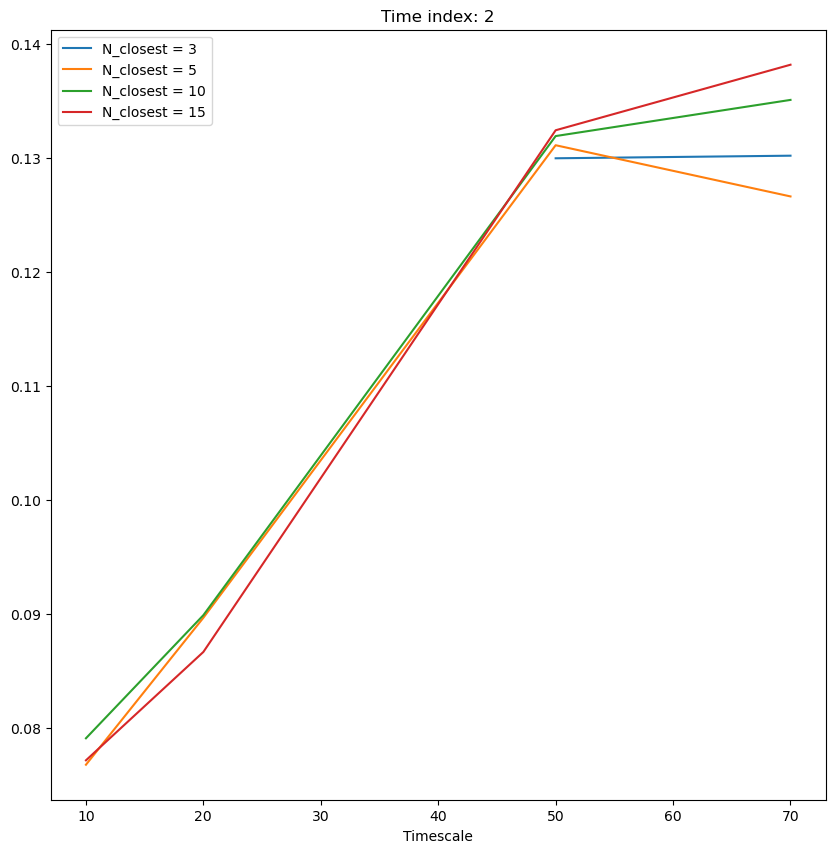

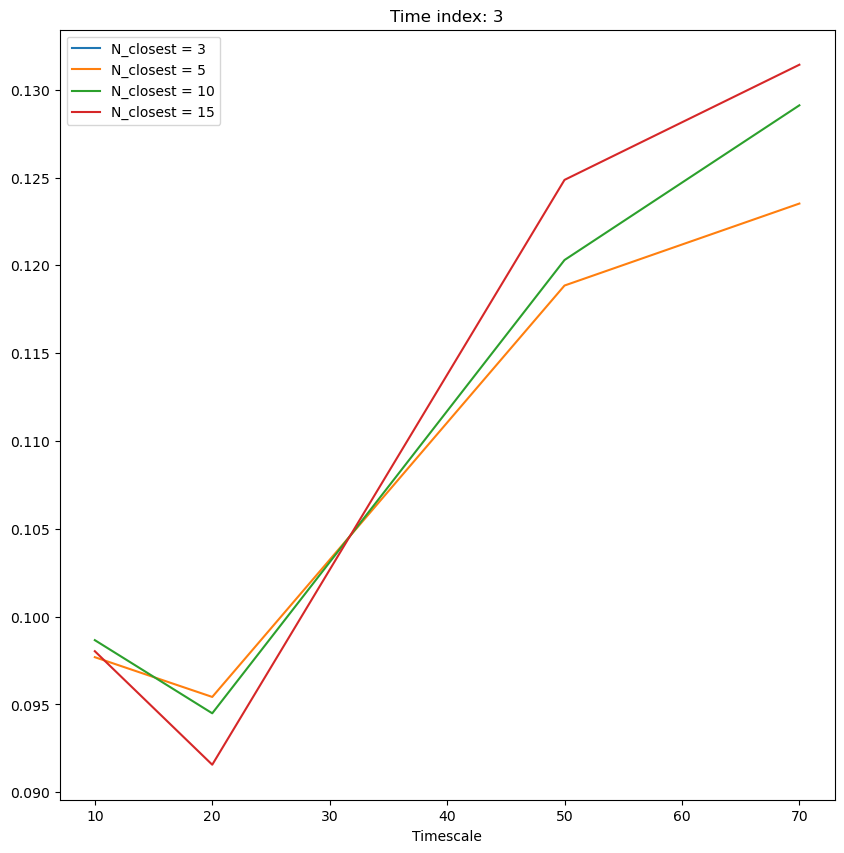

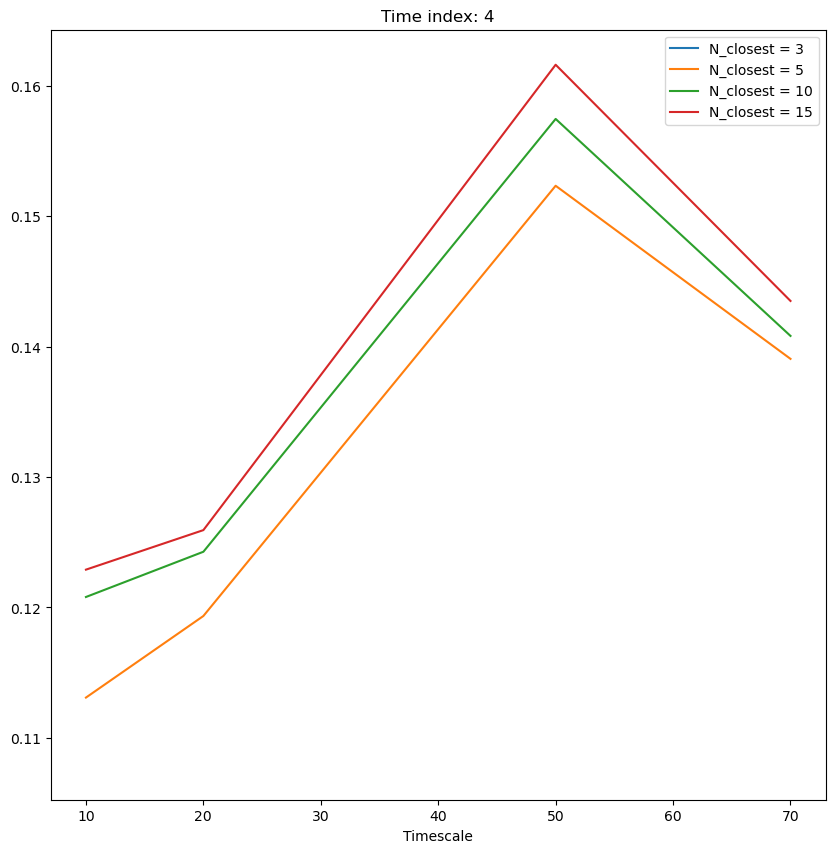

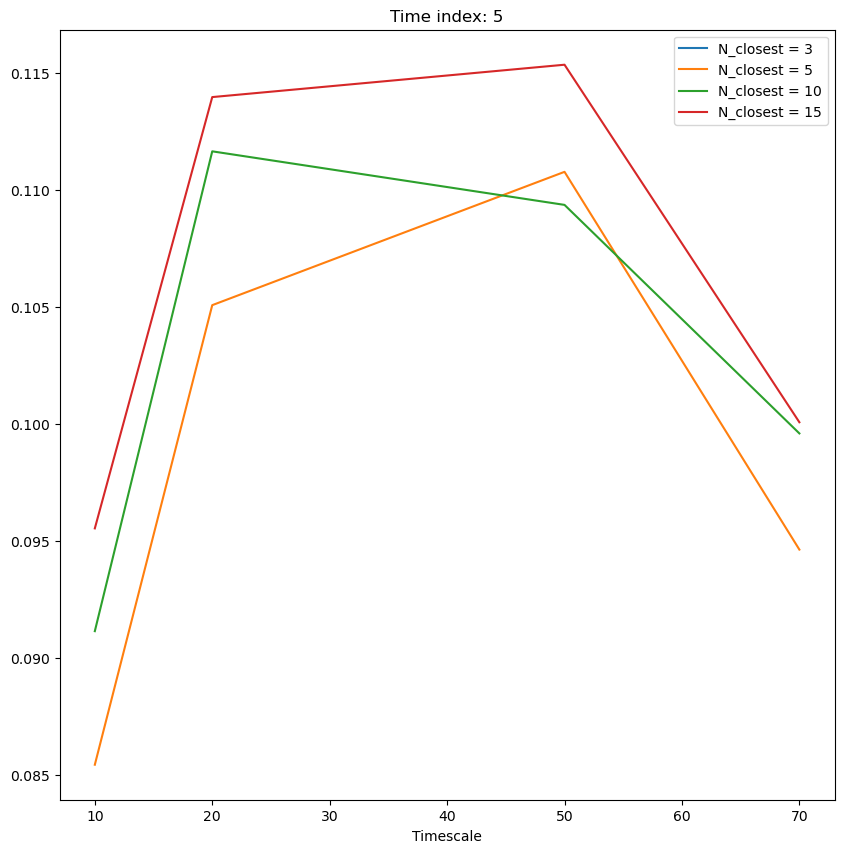

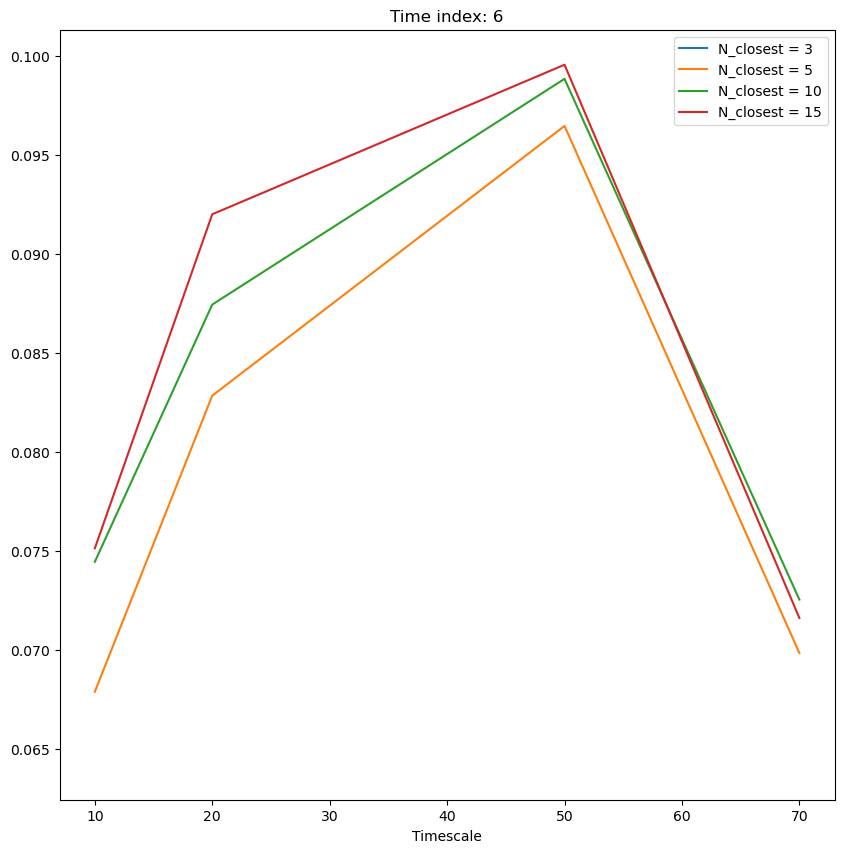

In [ ]:
for i, time_index in enumerate(time_indices):
    plt.figure(figsize = (10,10))
    plt.title(f"Time index: {time_index}")
    for j, N in enumerate(N_closest):
        plt.plot(timescales, overview[i,j], label = f"N_closest = {N}")

    plt.xlabel('Timescale')
    plt.legend()
    plt.show()

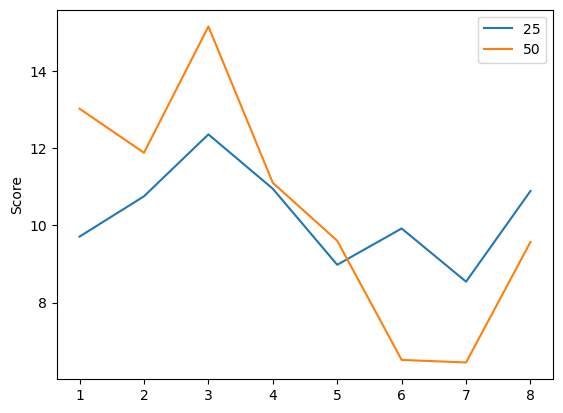

In [ ]:
plt.plot(np.array(ss)*100, label = '25')
plt.plot(np.array(ss50)*100, label = '50')
plt.ylabel('Score')
plt.legend()
plt.show()

No handles with labels found to put in legend.


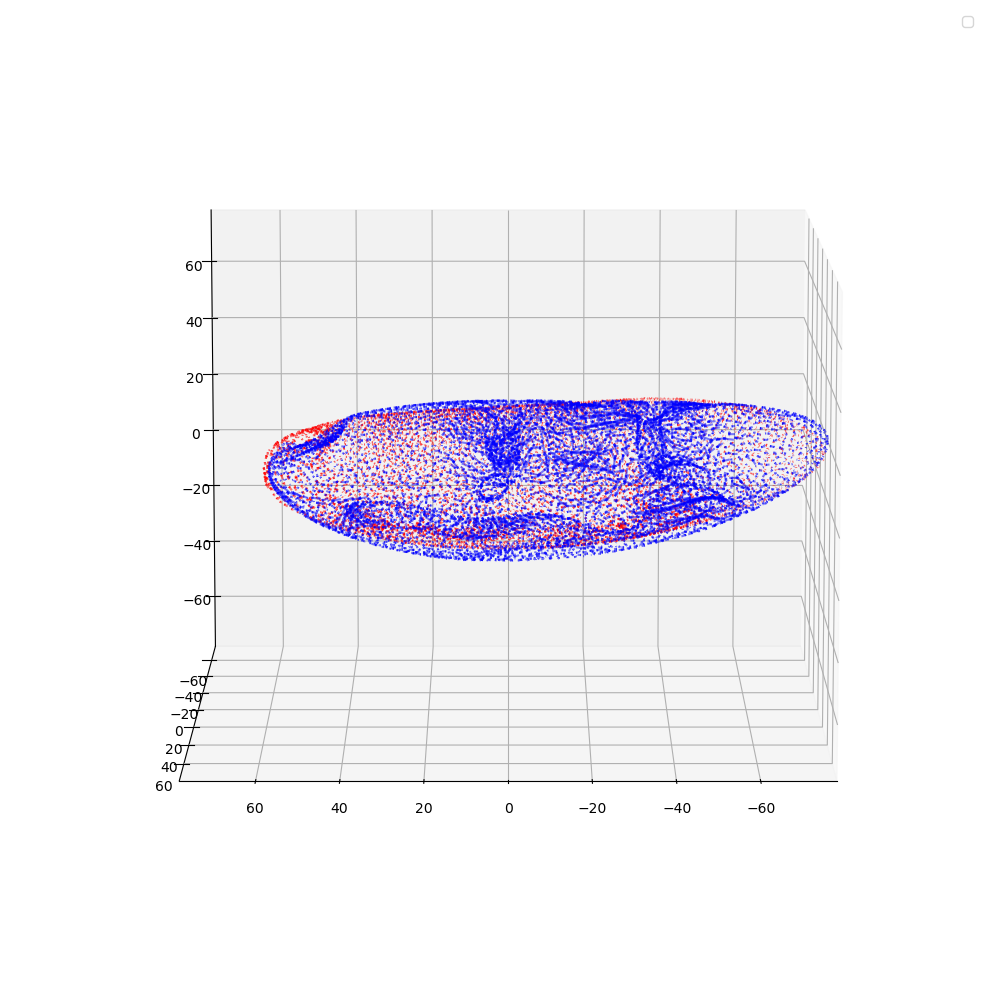

In [ ]:
# draw quiver plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tracked_and_rescaled = pd.read_csv('../DeconstructingGastrulation-Data/tracked_data_rescaled.csv')

fig = plt.figure(figsize = (10,10), tight_layout = True)
ax = fig.add_subplot(111, projection='3d',)
frame1 = tracked_and_rescaled[tracked_and_rescaled['frame'] == 5]

# ax.scatter(frame1['x'], frame1['y'], frame1['z'], c='r', marker='.', alpha = 1, label = 'Stas', s = 40, edgecolors='k', zorder = 10)
ax.quiver(frame1['x'], frame1['y'], frame1['z'], frame1['dx'], frame1['dy'], frame1['dz'], color = 'r', alpha = 0.5)


x,y,z = sim[5*50].T

d = sim[6*50].T - sim[5*50].T
# ax.scatter(x, y, z, c='b', marker='.', alpha = 1, label = 'Simulation', s = 40, edgecolors='k')
ax.quiver(x, y, z, d[0], d[1], d[2], color = 'b', alpha = 0.5)

plt.xlim(-75,75)

plt.ylim(-75,75)
ax.set_zlim(-75,75)

# set the camera angle
ax.view_init(elev=10, azim=90)

plt.legend()
plt.show()
# draw quiver plot